# Using Python with Excel (and csv) files

Our objective is to present some practical ways Python can be used to automate working with Excel files. Some tools include:

* pandas - `read_excel`, `ExcelWriter`, `to_excel`
* openpyxl
* https://xlsxwriter.readthedocs.io/working_with_tables.html
* xlwings - https://pbpython.com/xlwings-pandas-excel.html

Note: It appears that xlrd and xlwt are not longer being maintained. Use openpyxl instead.

Potential topics incude:

* reading csv and Excel files into pandas dataframes
    - nicely formatted
    - not nicely formatted (see, e.g., https://pbpython.com/pandas-excel-range.html)
* consolidating data from/to Excel files 
    - across cols within a sheet
    - across sheets within a workbook
    - across workbooks
* combining mix of csv and Excel files using combinations of techniques above


## Good resources

* https://www.datacamp.com/community/tutorials/python-excel-tutorial
* Excel Hell presentation: https://github.com/chris1610/pbpython/blob/master/presentations/Escaping-Excel-Hell-with-Python-and-Pandas.pdf


In [31]:
import pandas as pd

## Prelude - Review of reading json, csv and Excel files with Python
Back in the pcda class, I included some optional material on reading json, csv, and Excel files using Python. In those short lessons, I also included some good info on using PyCharm effectively and basic package management with conda and pip. Before launching into new material, I encourage you to take a quick look at these for a refresher. For your convenience, I've included the notebooks and Python scripts in this module's Downloads file. You can find the screencasts at:

* http://www.sba.oakland.edu/faculty/isken/courses/mis5470_w21/python_intro_2.html#optional-advanced-activities



## Combining and splitting of data in csv and Excel files
We will start with a few examples motivated by common scenarios such as:

* You have a whole folder full of csv (or Excel) files with the same file structure and you need to combine them into a single file. You might also need to make some changes to the consolidated file.
* You have an Excel file with multiple sheets of similarly structured data and you want to consolidate them into a single sheet.
* You have an Excel file with data in "wide" format and you need to convert it to long format, and then perhaps export out individual files (one per the key column(s) in the long formatted data).
* You have an Excel file acting as a simple flatfile database. Periodically, you get new Excel files that need to get appended to the "database" file.

## Example 1 - Concatenating csv files

As part of a [research project on hospital capacity planning](http://hselab.org/comparing-predictive-models-for-obstetrical-unit-occupancy-using-caret-part-1.html), I ended up
running many computer simulations. For example, there were 150 different
scenarios, each requiring 25 runs (replications) of the simulation model. Each
run generated a log file that was subsequently processed by a Python script. Much
of this post-processing took place in parallel threads with a subset of the
scenarios allocated to each thread. After all that, I ended up with a
subdirectory containing a number of csv files with identical structure that
needed to be combined into one big csv file. Here's a little bit of one of
the files.

```
  scenario,rep,timestamp,num_days,num_visits_obs,num_visits_ldr,num_visits_pp, ...
  30,1,2016-03-04 12:44:29.610563,105553,42150.0,42154.0,42159.0,8409.0, ...
  30,10,2016-03-04 12:48:00.519651,105553,42288.0,42296.0,42305.0,8500.0, ...
  30,11,2016-03-04 12:51:30.571655,105553,42210.0,42209.0,42227.0,8387.0, ...
  30,12,2016-03-04 12:55:08.550450,105553,42420.0,42433.0,42457.0,8341.0, ...
  30,13,2016-03-04 12:58:48.635709,105553,42277.0,42289.0,42301.0,8429.0, ...
  30,14,2016-03-04 13:02:21.325709,105553,42127.0,42135.0,42150.0,8581.0, ...
  ... many more rows and columns
```

I also wanted to make sure that the final combined file was sorted in
ascending order by scenario by replication. Even though I only had a handful
of files, manually doing the concatenation using Excel and copying and pasting
got old quickly. Also, I often face this same problem but have hundreds of csv
files to concatenate. Seems like a good excuse to put together a Python script
to address this problem.

Here is a directory listing of the files to be concatenated.


```
 Directory of C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\sim_output

03/31/2021  06:56 AM    <DIR>          .
03/31/2021  06:56 AM    <DIR>          ..
02/26/2016  01:15 PM           260,332 results_Exp9_Tandem05_nodischadj_0.csv
02/27/2016  06:49 AM         1,466,932 results_Exp9_Tandem05_nodischadj_100.csv
02/26/2016  07:18 PM           585,564 results_Exp9_Tandem05_nodischadj_1_2.csv
02/26/2016  11:05 PM           876,058 results_Exp9_Tandem05_nodischadj_3_5.csv
02/27/2016  02:16 AM         1,170,356 results_Exp9_Tandem05_nodischadj_6_9.csv
               5 File(s)      4,359,242 bytes
```
As you can tell from the listing, this is on a Windows system. However, we want a solution that
works on Windows, Linux or Mac. The backslash vs forward slash issue in file paths can cause grief. When I [first developed a Python solution](http://hselab.org/concat-csv-pandas.html) for this problem (on a Linux system), I did the typical thing and used the built in `os` and `glob` libraries in Python to work with file paths and the file system. Since then, I've learned about the newish system library called `pathlib`. Let's start by checking out these libraries.


## Working with paths and folders and the os

For tasks like the one above and many similar such tasks, we need a way to work with the file system and file paths. We can use the `os` module for working with paths and doing things like navigating directories, and moving or copying files. In addition, the `glob` module is handy for getting lists of files based on a filename pattern.

An alternative to `os` and `glob` is the object oriented `pathlib` moddule. Let's take a quick look at both of these approaches. This is **NOT** meant to be a comprehensive tutorial on `pathlib`. There's a really good post on it in Practical Business Python entitled [Using Python's pathlib module](https://pbpython.com/pathlib-intro.html). And, a good two part series on `pathlib` was done by Python blogger, Trey Hunter:

* [Why you should be using pathlib](https://treyhunner.com/2018/12/why-you-should-be-using-pathlib/)
* [No really, pathlib is great](https://treyhunner.com/2019/01/no-really-pathlib-is-great/)

Of course, the [official `pathlib` docs](https://docs.python.org/3/library/pathlib.html) are really useful - there's even a [table of os and pathlib equivalents](https://docs.python.org/3/library/pathlib.html#correspondence-to-tools-in-the-os-module).



### Using os and glob
This is just a glimpse at a few operations with `os`. One thing to note is that the result of things like `getcwd` is a string.

In [1]:
import os
from glob import glob

In [64]:
os.chdir("..")

In [2]:
# Retrieve current working directory (`cwd`)
cwd = os.getcwd()
print(cwd)
print(type(cwd))

# Change directory
os.chdir("./data")

# List all files and directories in current directory
print(os.listdir('.'))

# Use glob to get all the csv filenames
for csv_fn in glob("*.csv"):
    print(csv_fn)

# Change back to original working directory
os.chdir("..")

C:\Users\isken\Documents\teaching\aap_s21\excel_with_python
<class 'str'>
['ACE', 'AF', 'AM', 'apache-mini.log', 'data-text.csv', 'data-text.json', 'interval', 'sim_output', 'siteA_loc1_shallow.csv', 'sites_1_6.xlsx', 'SOWC 2014 Stat Tables_Table 9.xlsx']
data-text.csv
siteA_loc1_shallow.csv


### Using pathlib

Now let's get a brief introduciton to `pathlib`. Again, check out the links above for thorough tutorials.

First, let's import the `Path` object from `pathlib`.

In [3]:
from pathlib import Path

Get the current working directory. Notice that the result is not a string; it's a `WindowsPath` object. If we were on Linux, it would be a `PosixPath` object.

In [4]:
Path.cwd()

WindowsPath('C:/Users/isken/Documents/teaching/aap_s21/excel_with_python')

You can build up path objects using the `/` operator.

In [5]:
data_dir = Path.cwd() / "data"
data_dir

WindowsPath('C:/Users/isken/Documents/teaching/aap_s21/excel_with_python/data')

We can also build up paths using the `Path` object. Note in this example, we get a relative path.

In [6]:
in_file_1 = Path("data", "data-text.csv")
in_file_1

WindowsPath('data/data-text.csv')

If we wanted the absolute path associated with this relative path, we just use the `absolute` method.

In [8]:
in_file_1.absolute()

WindowsPath('C:/Users/isken/Documents/teaching/aap_s21/excel_with_python/data/data-text.csv')

We can get the parts of a path with the `parts` method.

In [9]:
in_file_1.parts

('data', 'data-text.csv')

Another way to build up path objects is with the `joinpath` method.

In [10]:
in_file_2 = Path.cwd().joinpath("data").joinpath("data-text.csv")
in_file_2

WindowsPath('C:/Users/isken/Documents/teaching/aap_s21/excel_with_python/data/data-text.csv')

To do globbing we can use `pathlib`'s `glob` and `rglob` methods. It's important to note that these return generators - i.e. they don't actually compute all the values until asked. The 'r' in `rglob` stands for *recursive* and means it will dive down into subdirectories looking for filenames that match the specified pattern. The `glob` version just looks in the current directory.

In [15]:
data_dir.rglob('*.csv')

<generator object Path.rglob at 0x000001D33E32DF20>

In [16]:
for f in data_dir.rglob('*.csv'):
    print(f)

C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\data-text.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\siteA_loc1_shallow.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_1_RIP_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_1_STR_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_2_RIP_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_2_STR_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_3_RIP_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_3_STR_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_4_RIP_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF\US_4_STR_D_AF.csv
C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\sim_output\results_Exp9_Tandem05_nodischadj_0.csv
C:\Users\isken\Documents\teach

Let's repeat using `glob` and just print the fiename and its component parts instead of the whole path.

In [28]:
for f in data_dir.glob('*.csv'):
    print(f"filename = {f.name}, stem = {f.stem}, suffix = {f.suffix}")

filename = data-text.csv, stem = data-text, suffix = .csv
filename = siteA_loc1_shallow.csv, stem = siteA_loc1_shallow, suffix = .csv


The `iterdir` method returns `Path` objects for everything in the directory from which it is used. It's somewhat like `os.listdir`.

In [19]:
for d in data_dir.iterdir():
    print(type(d), d)

<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\ACE
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AF
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\AM
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\apache-mini.log
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\data-text.csv
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\data-text.json
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\interval
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\sim_output
<class 'pathlib.WindowsPath'> C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\data\siteA_loc1_shallow.csv
<class 'pathlib.WindowsPath'> C:\Users\isken\Do

The `pathlib` module includes methods for common filesystem operations. For example, let's create a new directory called `csvs` in our current working directory. Then let's find and copy all of the csv files that are in the `data` folder or any subfolders inside of `data`. Unfortunately, there isn't an actual `copy` method in `pathlib` that copies files (including metadata). For that part we need to use the built in `shutil` library. The `pathlib` modules does have a `rename` method that essentially allows you to move files and `write_bytes` and `write_text` which allows you to copy file contents.

In [25]:
import shutil

In [24]:
# Create a Path object corresponding to the new directory name
csvs_dir = Path.cwd() / 'csvs'
print(csvs_dir)
# Make the new directory
csvs_dir.mkdir(exist_ok=True)  # Since we are just practicing, we'll overwrite the directory if it already exists.
# The Path module has several useful is_* functions
print(csvs_dir.is_dir())

C:\Users\isken\Documents\teaching\aap_s21\excel_with_python\csvs
True


Now we can use `rglob` along with `shutil.copy` to actually copy the files.

In [26]:
for f in data_dir.rglob('*.csv'):
    shutil.copy(f, csvs_dir)

## Back to Example 1 - Concatenating csv files

Now that we know how to work with `pathlib`, let's sketch out a strategy for combining all of the csv files in the `sim_output` directory into a single consolidated csv file, named `sim_output.csv`. Let's put the consolidated file in the `data` folder. As mentioned earlier, the consolidate file should be sorted by `scenario` and `rep`.

* Create `Path` objects for the source and destination of our files
* Create an empty dictionary that will store the intermediate `DataFrame` objects as they get created.
* Use `pathlib.glob` to loop over all the csv files in the source directory
    - Get the filename stem of the current csv file
    - read the csv file into a pandas DataFrame
    - store the DataFrame in our dictionary using the stem as the key
* Use the pandas `concat` function to concatenate the dataframes in the dictionary, creating the consolidated `DataFrame`
* Sort the consolidated `DataFrame` by scenario and rep
* Export the consolidated `DataFrame` to a csv file in the desired location

In [33]:
# Inputs
csvs_path = Path.cwd() / 'data' / 'sim_output'
dest_path = Path.cwd() / 'data' / 'sim_output.csv'

sortkeys = ['scenario', 'rep']

# Create empty dict to hold the DataFrames created as we read each csv file
dfs = {}

# Loop over all the csv files 
for csv_f in csvs_path.glob('*.csv'):
    # Split the filename off from csv extension. We'll use the filename
    # (without the extension) as the key in the dfs dict.
    fstem = csv_f.stem

    # Read the next csv file into a pandas DataFrame and add it to
    # the dfs dict.
    df = pd.read_csv(csv_f)
    dfs[fstem] = df

# Use pandas concat method to combine the file specific DataFrames into
# one big DataFrame.
bigdf = pd.concat(dfs)

# Since we didn't try to control the order in which the files were read,
# we'll sort the final DataFrame in place by the specified sort keys.
bigdf.sort_values(sortkeys, inplace=True)

# Export the final DataFrame to a csv file. Suppress the pandas index.
bigdf.to_csv(dest_path, index=False)

## Example 2 - Consolidating data from multiple sheets in a Excel file using pandas

If you reviewed the `reading_excel_data.ipynb` notebook (and the associated `reading_excel_data.py` file) , you saw that we had some stream temperature data on six different sheets. In that notebook and Python script, we used the xlrd library as well as the openpyxl library to consolidate the data into a single csv file. 

![sites_1_6](images/sites_1_6.png)

While libraries like openpyxl are quite powerful and let you really dig into the details of reading and writing Excel files with Python, sometimes you can get by with a simpler approach. In this case, each sheet is structured the same:

* header in first row
* data follows

Pandas includes a quite powerful and flexible `read_excel` function that is more than up to the task. Let's check it out at https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html.

Notice that the default `sheet_name=0` which means only the first sheet is read. To read all the sheets, we need `sheets=None` We have a header in the first row and `header=0` is default, so we can take the default. The following should read all the sheets and return an `OrderedDict` whose keys are the sheet names. 

Also, we see that `read_excel`, while happy to accept a filename, is also happy to accept at `Path` object.

In [47]:
sites_1_6_xl = Path('data', 'sites_1_6.xlsx')
sites_1_6_consolidated_xl = Path('data', 'sites_1_6_consolidated.xlsx')
sites_1_6_consolidated_csv = Path('data', 'sites_1_6_consolidated.csv')  # We'll try this in a bit
sites_1_6_xl

WindowsPath('data/sites_1_6.xlsx')

In [45]:
sites_all = pd.read_excel(sites_1_6_xl, sheet_name=None)

In [46]:
sites_all.keys()

dict_keys(['Site1', 'Site2', 'Site3', 'Site4', 'Site5', 'Site6'])

In [39]:
sites_all['Site1']

,datetime,temp_c
0,09/15/15 12:00:00 PM,10.222
1,09/15/15 01:00:00 PM,10.320
2,09/15/15 02:00:00 PM,10.443
3,09/15/15 03:00:00 PM,10.492
4,09/15/15 04:00:00 PM,10.565
...,...,...
834,10/20/15 06:00:00 AM,10.785
835,10/20/15 07:00:00 AM,10.761
836,10/20/15 08:00:00 AM,10.736
837,10/20/15 09:00:00 AM,10.736


Now let's add a new column to each dataframe corresponding to the sheet name and then consolidate all the dataframes into a single dataframe.

In [40]:
sheet_names = sites_all.keys()
for sheet_name in sheet_names:
    # Add new col
    sites_all[sheet_name]['site'] = sheet_name

# Ignore the index so that we don't get a multi-index based on the sheet name
consolidated_df = pd.concat(sites_all, ignore_index=True)
consolidated_df

,datetime,temp_c,site
0,09/15/15 12:00:00 PM,10.222,Site1
1,09/15/15 01:00:00 PM,10.320,Site1
2,09/15/15 02:00:00 PM,10.443,Site1
3,09/15/15 03:00:00 PM,10.492,Site1
4,09/15/15 04:00:00 PM,10.565,Site1
...,...,...,...
5029,10/20/15 06:00:00 AM,11.151,Site6
5030,10/20/15 07:00:00 AM,11.127,Site6
5031,10/20/15 08:00:00 AM,11.127,Site6
5032,10/20/15 09:00:00 AM,11.078,Site6


Now we can write it back out to an Excel file. Let's not include the index. After running the next command, we'll go look at the resulting Excel file.

In [48]:
consolidated_df.to_excel(sites_1_6_consolidated_xl, index=None)

For another approach we could use the openpyxl library. While not really needed with this nicely formatted Excel file, sometimes we need finer control over what we are reading in from Excel. This simple example shows how to access specific sheets and cells. I've written it as a function that accepts filenames. Hmmm, I wonder if openpyxl is now open to accepting `Path` objects. Let's try it.

In [54]:
import openpyxl
import csv

In [55]:
def consolidate_logger_xlsheets_openpyxl(fn_xlsx, fn_csv, verbose=True):
    """
    Combine xlsx sheets and output as csv using openpyxl

    Args:
        fn_xlsx: filename of Excel file to process
        fn_csv:  filename of output CSV file
        verbose: If true (default), writes status messages
    Returns:
        nothing, just writes CSV file

    """
    # Open the workbook
    wb_sites = openpyxl.load_workbook(fn_xlsx)

    # Accumulate the rows (lists) into another list. 
    # We'll end up with a list of lists.
    data = []
    for ws in wb_sites:
        if verbose:
            print("openpyxl:", ws.title)

        site = ws.title

        # Get the rows for the current sheet
        #for row in ws.rows[1:]:
        for row in ws.iter_rows():
            ws_data = [cell.value for cell in row]
            ws_data.append(site)
            data.append(ws_data)

    if verbose:
        print("openpyxl:", "Total number of rows: ", len(data), "\n")


    # Write CSV file
    with open(fn_csv, "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [56]:
consolidate_logger_xlsheets_openpyxl(sites_1_6_xl, sites_1_6_consolidated_csv, verbose=True)

openpyxl: Site1
openpyxl: Site2
openpyxl: Site3
openpyxl: Site4
openpyxl: Site5
openpyxl: Site6
openpyxl: Total number of rows:  5040 



Brilliant, it works! It seems like `pathlib` is getting good adoption and just this little bit I've used it has won me over.

## Dealing with wide data and a multi-row header - CHALLENGE
For the next Excel data wrangling task, you will do the work. In the `data` folder you'll find an Excel file named `temp_data_wide.xlsx`. This was actually a real file we received from Antarctica during our stream temperature related research project. Usually we would get the data from each temperature logger in a separate Excel or csv file. But, many times, the scientists collecting the data would do a little Excel data prep on their own and combine the files into a single Excel file with separate columns for each data logger. The example file I've provided looks like this:

![temp_data_wide.xlsx](images/temp_data_wide.png)

Our eventual goal is to read this Excel file and create the following outputs. Each should end up in the `output` folder. You can find examples of my solution outputs in that folder.

### Excel file in long form

We want a new Excel file that has the data in "long" form. In other words, it should look like the following. Notice the new column names - your should have these same column names.

![temp_data_long](images/temp_data_long.png)

**HINT:** `melt`

### Excel file containing summary stats

We also want an Excel file containing summary stats by `loc_id`. It should look like this:

![summary_stats.png](images/summary_stats.png)

**HINT:** `describe`

### A plot of the data

Finally, we want a faceted plot. It should look like this:

![temp_data_plot_soln.png](images/temp_data_plot_soln.png)

**HINT:** Seaborn



Just try to get each piece working in the order presented above. You do **NOT** need tools like openpyxl. A combination of pandas, pathlib, matplotlib, and Seaborn is enough to do this. Once you've got all the pieces working and generating the correct outputs, then it's time to turn this into a reusable function. Our function would take the following inputs:

* **file** - a path object or Excel filename for the wide formatted data
* **long_file** (default=None) - a path object or Excel filename for the long formatted Excel file to create
* **stats** (default=None) - a path object or Excel filename for the summary stats Excel file to create
* **plot** (default=None) - a path object or png filename for the plot to create

The **file** argument is required. The other named arguments are optional and default to None. If their value is None, then our function won't output that particular entity.

## Processing text files and storing in consolidate Excel workbook

Use interval data example - see `data/interval`.

## More on using Python for similar Excel tasks
Chris Moffit, in his Practical Business Python blog, covers topic very nicely. He has several posts that show how to use Python for common Excel tasks. These include:

* [Combining Data From Multiple Excel Files](https://pbpython.com/excel-file-combine.html) - file globbing, concatenating dataframes,
* [Reading Poorly Structured Excel Files with Pandas](https://pbpython.com/pandas-excel-range.html) - advanced use of `read_excel`, accessing ranges and Table
* [Common Excel Tasks Demonstrated in Pandas](https://pbpython.com/excel-pandas-comp.html)
* [Common Excel Tasks Demonstrated in Pandas - Part 2](https://pbpython.com/excel-pandas-comp-2.html)



## Dealing with wide data and a multi-row header - SOLUTION

First I got it working in steps. Then I turned it into a function.

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# Create Path objecst for Excel file to process, summary stats and plot to output
temp_data_wide_xl = Path('data', 'temp_data_wide.xlsx')
temp_data_long_xl = Path('output', 'temp_data_long_soln.xlsx')
temp_data_stats_xl = Path('output', 'temp_data_stats_soln.xlsx')
temp_data_plot_png = Path('output', 'temp_data_plot_soln.png')

In [96]:
# Read into pandas with read_excel. Need to skip rows 1 and 2.
temp_data_wide_df = pd.read_excel(temp_data_wide_xl, header=0, skiprows=[1,2])
temp_data_wide_df

,Label,EC-01-STR-U-ACE,EC-02-STR-U-ACE,EC-03-STR-U-ACE,EC-04-STR-U-ACE,EC-04-RIP-U-ACE
0,2016-01-21 13:00:00,19.948,19.948,19.853,NaN,18.521
1,2016-01-21 13:15:00,19.948,19.948,19.853,20.519,18.521
2,2016-01-21 13:30:00,19.948,19.948,19.853,20.329,18.521
3,2016-01-21 13:45:00,19.948,19.948,19.853,20.519,18.426
4,2016-01-21 14:00:00,19.948,19.948,19.853,20.519,18.426
...,...,...,...,...,...,...
1233,2016-02-03 09:15:00,19.758,19.662,19.758,20.043,20.138
1234,2016-02-03 09:30:00,19.758,19.662,19.758,20.043,20.043
1235,2016-02-03 09:45:00,19.758,19.758,19.758,20.043,20.043
1236,2016-02-03 10:00:00,19.853,19.758,19.758,20.043,19.948


In [97]:
# Rename the Label col to datetime
temp_data_wide_df.rename({'Label': 'datetime'}, axis=1, inplace=True)
temp_data_wide_df

,datetime,EC-01-STR-U-ACE,EC-02-STR-U-ACE,EC-03-STR-U-ACE,EC-04-STR-U-ACE,EC-04-RIP-U-ACE
0,2016-01-21 13:00:00,19.948,19.948,19.853,NaN,18.521
1,2016-01-21 13:15:00,19.948,19.948,19.853,20.519,18.521
2,2016-01-21 13:30:00,19.948,19.948,19.853,20.329,18.521
3,2016-01-21 13:45:00,19.948,19.948,19.853,20.519,18.426
4,2016-01-21 14:00:00,19.948,19.948,19.853,20.519,18.426
...,...,...,...,...,...,...
1233,2016-02-03 09:15:00,19.758,19.662,19.758,20.043,20.138
1234,2016-02-03 09:30:00,19.758,19.662,19.758,20.043,20.043
1235,2016-02-03 09:45:00,19.758,19.758,19.758,20.043,20.043
1236,2016-02-03 10:00:00,19.853,19.758,19.758,20.043,19.948


In [108]:
# Reshape the data from wide to long
temp_data_long_df = temp_data_wide_df.melt(id_vars=['datetime'], var_name='loc_id', value_name='temp_c')
temp_data_long_df.to_excel(temp_data_long_xl, index=None)
temp_data_long_df

,datetime,loc_id,temp_c
0,2016-01-21 13:00:00,EC-01-STR-U-ACE,19.948
1,2016-01-21 13:15:00,EC-01-STR-U-ACE,19.948
2,2016-01-21 13:30:00,EC-01-STR-U-ACE,19.948
3,2016-01-21 13:45:00,EC-01-STR-U-ACE,19.948
4,2016-01-21 14:00:00,EC-01-STR-U-ACE,19.948
...,...,...,...
6185,2016-02-03 09:15:00,EC-04-RIP-U-ACE,20.138
6186,2016-02-03 09:30:00,EC-04-RIP-U-ACE,20.043
6187,2016-02-03 09:45:00,EC-04-RIP-U-ACE,20.043
6188,2016-02-03 10:00:00,EC-04-RIP-U-ACE,19.948


In [109]:
# Compute the summary stats
summary_stats = temp_data_long_df.groupby(['loc_id'])['temp_c'].describe()
summary_stats.to_excel(temp_data_stats_xl)
summary_stats

,count,mean,std,min,25%,50%,75%,max
loc_id,,,,,,,,
EC-01-STR-U-ACE,1238.0,19.997498,0.370441,18.996,19.758,20.043,20.234,20.710
EC-02-STR-U-ACE,1238.0,19.982544,0.467937,18.711,19.662,19.948,20.329,20.901
EC-03-STR-U-ACE,1238.0,20.073852,0.382631,19.092,19.758,20.043,20.329,20.901
EC-04-RIP-U-ACE,1238.0,21.081518,3.342630,14.421,18.616,20.234,23.292,29.652
EC-04-STR-U-ACE,1237.0,20.368574,0.586291,18.996,19.948,20.329,20.710,23.100


Finally create the faceted plot.

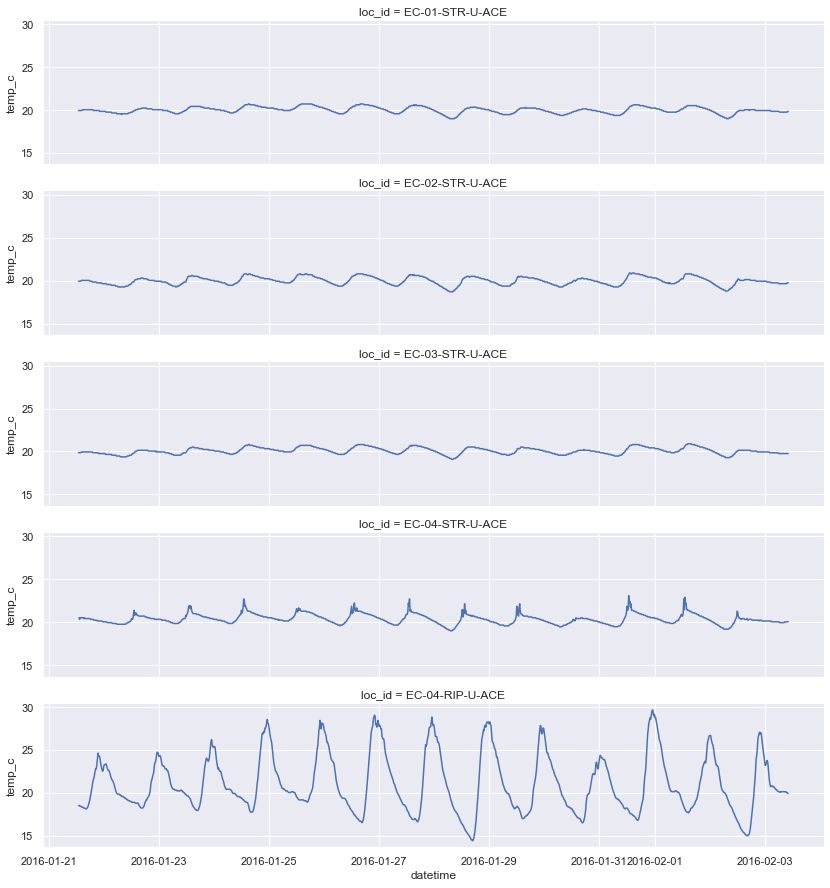

In [113]:
temp_g = sns.FacetGrid(temp_data_long_df, row="loc_id", sharey=True, height=2.5, aspect=11.7/2.5)
temp_g = temp_g.map(plt.plot, "datetime", "temp_c")
temp_g.savefig(temp_data_plot_png)

